In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
numpy = lambda x : x.detach().cpu().numpy().squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.__version__

import pyrtools as pt
from plenoptic import synth
from plenoptic import simul
import plenoptic

In [11]:
model = simul.Linear()
image = plt.imread('../data/nuts.pgm').astype(float)/255.
im0 = torch.tensor(image, requires_grad=True, dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)
M = synth.Metamer(im0, model)
matched_image, matched_representation = M.synthesize(max_iter=300, learning_rate=1,seed=1)

100%|██████████| 300/300 [00:10<00:00, 27.42it/s, gradient_norm=5.7962e-02, learning_rate=0.0016, loss=3.0916e-03]


In [12]:
M.matched_representation.shape

torch.Size([1, 5, 250, 250])

Difference statistics:
  Range: [0, 0]
  Mean: 0.000001,  Stdev (rmse): 0.000212,  SNR (dB): 64.644608


(-0.013808515609479419,
 0.044317424297332764,
 7.090113672118065e-07,
 0.00021155191106593277,
 64.64460822151055)

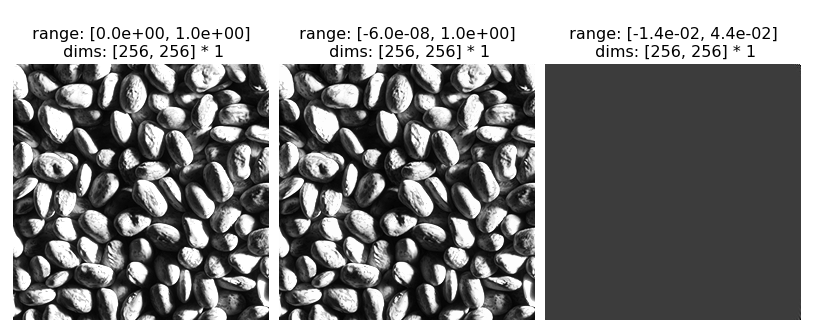

In [13]:
pt.imshow([image, numpy(M.matched_image), image - numpy(M.matched_image)]);
pt.image_compare(image, numpy(M.matched_image))

100%|██████████| 200/200 [00:04<00:00, 37.72it/s, gradient_norm=1.6757e-03, learning_rate=5.12e-7, loss=2.3141e+00]


tensor(0.)


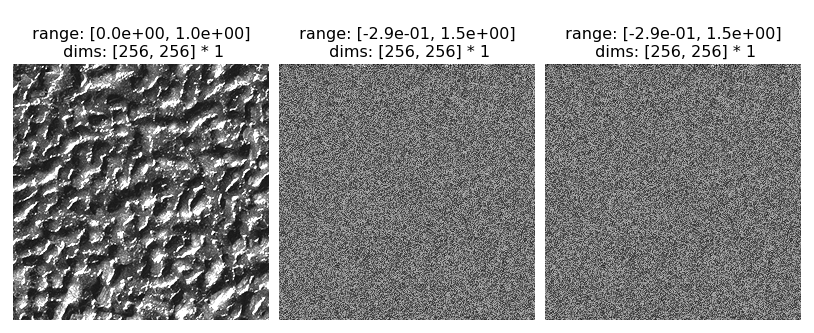

In [14]:
# Test that seed = 1 generates the same image
model = simul.Linear_Nonlinear()
image = plt.imread('../data/metal.pgm').astype(float)/255
im0 = torch.tensor(image,requires_grad=True,dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)
M = synth.Metamer(im0, model)
matched_image, matched_representation = M.synthesize(max_iter=200, learning_rate=1,seed=0)
matched_image2, matched_representation2 = M.synthesize(max_iter=200, learning_rate=1,seed=0)

pt.imshow([image, numpy(matched_image), numpy(matched_image2)]);
print(sum(sum((matched_image-matched_image2))))

100%|██████████| 200/200 [00:04<00:00, 40.00it/s, gradient_norm=1.9614e-04, learning_rate=4.1e-9, loss=7.4914e-01] 


tensor(-42.8655)


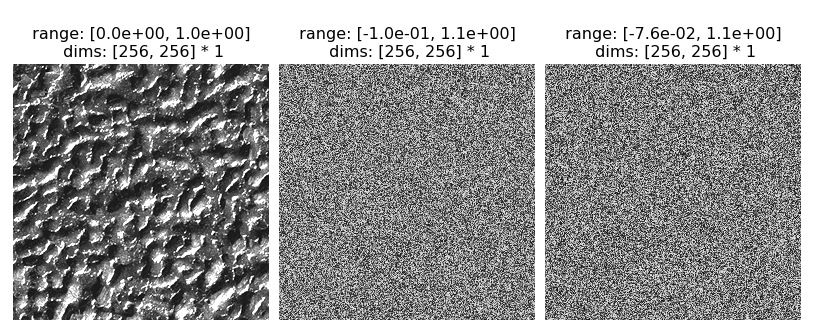

In [15]:
# Test that seed = 1 generates the a different image than seed = 0
model = simul.Linear_Nonlinear()
image = plt.imread('../data/metal.pgm').astype(float)/255
im0=torch.tensor(image,requires_grad=True,dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)
M = synth.Metamer(im0, model)
matched_image, matched_representation = M.synthesize(max_iter=200, learning_rate=1,seed=0)
matched_image2, matched_representation2 = M.synthesize(max_iter=200, learning_rate=1,seed=1)

pt.imshow([image, numpy(matched_image), numpy(matched_image2)]);
print(sum(sum((matched_image-matched_image2))))

100%|██████████| 200/200 [00:04<00:00, 40.85it/s, gradient_norm=1.7794e-03, learning_rate=2.56e-6, loss=2.3441e+00]


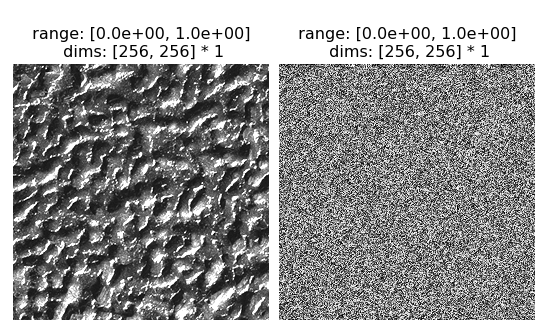

In [16]:
# Test clamping of weights using the range clamp
model = simul.Linear_Nonlinear()
image = plt.imread('../data/metal.pgm').astype(float)/255
im0=torch.tensor(image,requires_grad=True,dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)
M = synth.Metamer(im0, model)

rangeClamp = plenoptic.RangeClamper([im0.min().data,im0.max().data])
matched_image, matched_representation = M.synthesize(max_iter=200, 
    learning_rate=1,clamper=rangeClamp, seed=10)
pt.imshow([image, numpy(matched_image)]);


  2%|▏         | 4/200 [00:00<00:05, 38.68it/s, gradient_norm=6.3496e-01, learning_rate=1, loss=3.9631e+01]

(256, 256)


100%|██████████| 200/200 [00:05<00:00, 39.37it/s, gradient_norm=2.9886e-02, learning_rate=0.04, loss=1.5720e-02]


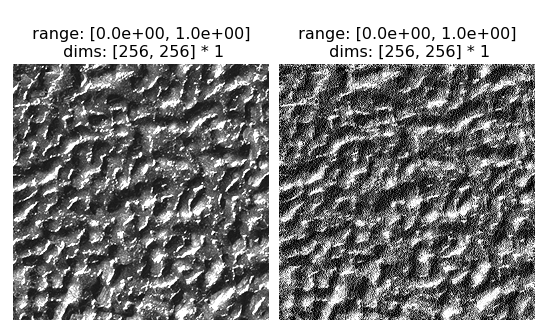

In [17]:
# Test saving statistics/image from all the iterations.  This can be used to visualize the
# path of the gradient descent in model/image space.
model = simul.Linear_Nonlinear()
image = plt.imread('../data/metal.pgm').astype(float)/255
print(image.shape)
im0=torch.tensor(image,requires_grad=True,dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)
M = synth.Metamer(im0, model)

rangeClamp = plenoptic.RangeClamper([im0.min().data,im0.max().data])
matched_image, matched_representation = M.synthesize(max_iter=200, clamper = rangeClamp,
    learning_rate=1, save_image=True, save_representation=False)
pt.imshow([image, numpy(matched_image)]);



In [18]:
pt.animshow(M.saved_image.squeeze().detach().numpy())


<PyrFigure size 522x320 with 2 Axes>

In [21]:
# Test Portilla Simoncelli 

# load image
image = plt.imread('../data/nuts.pgm').astype(float)/255
im0 = torch.tensor(image,requires_grad=True,dtype = torch.float32).squeeze().unsqueeze(0).unsqueeze(0)

# load measured samples
X = torch.tensor(np.load('metamer_PS_samples.npy'))
# calculate the normalization Factor from saved samples
normalizationFactor = X.std(dim=1)
normalizationFactor[normalizationFactor<.00001] = 1
normalizationFactor = normalizationFactor.pow(-1)

# set up a clamp for the pixel range
c = plenoptic.RangeClamper([image.min(), image.max()])

# synthesis
niter = 400
model = simul.Texture_Statistics(image.shape, normalize=True, normalizationFactor=normalizationFactor)
y = model.forward(im0)
M = synth.Metamer(im0, model)
matched_image, Matched_representation = M.synthesize(max_iter=niter, learning_rate=	1, 
    seed=np.random.randint(1000), clamper = c,save_image=True, loss_thresh=1)
pt.imshow([image, numpy(matched_image)]);


TypeError: __init__() got an unexpected keyword argument 'normalize'

In [3]:

pt.animshow(M.saved_image.squeeze().detach().numpy())